In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import folium
from folium.plugins import HeatMap
import folium
from folium.plugins import HeatMap, MarkerCluster
import plotly.express as px


### Carrega dados

In [2]:
dados = pd.read_excel('../data/CelularesSubtraidos_2023.xlsx')
dados = dados[dados['NOME_MUNICIPIO']=='RIBEIRAO PRETO']

In [3]:
print(len(dados))
dados.head(3)

4661


,ID_DELEGACIA,NOME_DEPARTAMENTO,NOME_SECCIONAL,NOME_DELEGACIA,NOME_MUNICIPIO,ANO_BO,NUM_BO,VERSAO,NOME_DEPARTAMENTO_CIRC,NOME_SECCIONAL_CIRC,...,DESCR_MODO_OBJETO,DESCR_TIPO_OBJETO,DESCR_SUBTIPO_OBJETO,DESCR_UNIDADE,QUANTIDADE_OBJETO,MARCA_OBJETO,FLAG_BLOQUEIO,FLAG_DESBLOQUEIO,MES,ANO
23380,900023,DIPOL - DEPTO DE INTELIGENCIA,DELEGACIA ELETRONICA,DELEGACIA ELETRONICA 3,RIBEIRAO PRETO,2023,AI6605,1,DEINTER 3 - RIBEIRAO PRETO,DEL.SEC.RIBEIRAO PRETO,...,Subtraído,Telecomunicação,Telefone Celular,NaN,1,Motorola,N,N,1,2023
23381,100919,DEINTER 3 - RIBEIRAO PRETO,DEL.SEC.RIBEIRAO PRETO,CPJ RIBEIRAO PRETO,RIBEIRAO PRETO,2023,AL6985,1,DEINTER 3 - RIBEIRAO PRETO,DEL.SEC.RIBEIRAO PRETO,...,Subtraído,Telecomunicação,Telefone Celular,Unidade,1,Motorola,NaN,NaN,1,2023
23382,100919,DEINTER 3 - RIBEIRAO PRETO,DEL.SEC.RIBEIRAO PRETO,CPJ RIBEIRAO PRETO,RIBEIRAO PRETO,2023,AL8902,1,DEINTER 3 - RIBEIRAO PRETO,DEL.SEC.RIBEIRAO PRETO,...,Subtraído,Telecomunicação,Telefone Celular,Unidade,1,Samsung,S,N,1,2023


### Entendimento dos Dados

In [8]:
print("Variáveis:")
print(dados.columns)

Variáveis:
Index(['ID_DELEGACIA', 'NOME_DEPARTAMENTO', 'NOME_SECCIONAL', 'NOME_DELEGACIA',
       'NOME_MUNICIPIO', 'ANO_BO', 'NUM_BO', 'VERSAO',
       'NOME_DEPARTAMENTO_CIRC', 'NOME_SECCIONAL_CIRC', 'NOME_DELEGACIA_CIRC',
       'NOME_MUNICIPIO_CIRC', 'DATA_OCORRENCIA_BO', 'HORA_OCORRENCIA',
       'DESCRICAO_APRESENTACAO', 'DATAHORA_REGISTRO_BO', 'DATA_COMUNICACAO_BO',
       'DATAHORA_IMPRESSAO_BO', 'DESCR_PERIODO', 'AUTORIA_BO',
       'FLAG_INTOLERANCIA', 'TIPO_INTOLERANCIA', 'FLAG_FLAGRANTE',
       'FLAG_STATUS', 'DESC_LEI', 'FLAG_ATO_INFRACIONAL', 'RUBRICA',
       'DESCR_CONDUTA', 'DESDOBRAMENTO', 'CIRCUNSTANCIA', 'DESCR_TIPOLOCAL',
       'DESCR_SUBTIPOLOCAL', 'CIDADE', 'BAIRRO', 'CEP', 'LOGRADOURO_VERSAO',
       'LOGRADOURO', 'NUMERO_LOGRADOURO', 'LATITUDE', 'LONGITUDE',
       'CONT_OBJETO', 'DESCR_MODO_OBJETO', 'DESCR_TIPO_OBJETO',
       'DESCR_SUBTIPO_OBJETO', 'DESCR_UNIDADE', 'QUANTIDADE_OBJETO',
       'MARCA_OBJETO', 'FLAG_BLOQUEIO', 'FLAG_DESBLOQUEIO', 'MES', 'ANO

Valores ausentes


Valores Ausentes por Coluna:

Distribuição de Valores Ausentes (Percentual):
TIPO_INTOLERANCIA         100.000000
DESDOBRAMENTO              98.605449
CIRCUNSTANCIA              88.285776
DESCR_UNIDADE              70.263892
HORA_OCORRENCIA            52.799828
PERIODO_DO_DIA             52.799828
DESCR_PERIODO              47.200172
DESCR_CONDUTA              22.720446
DESCR_TIPOLOCAL            20.381892
DESCR_SUBTIPOLOCAL         20.381892
LONGITUDE                  12.036044
LATITUDE                   12.036044
CEP                        10.491311
FLAG_DESBLOQUEIO            6.693843
FLAG_BLOQUEIO               6.693843
NUMERO_LOGRADOURO           5.535293
BAIRRO                      0.665093
CIDADE                      0.000000
LOGRADOURO_VERSAO           0.000000
ID_DELEGACIA                0.000000
LOGRADOURO                  0.000000
DESCR_MODO_OBJETO           0.000000
DESCR_TIPO_OBJETO           0.000000
DESCR_SUBTIPO_OBJETO        0.000000
QUANTIDADE_OBJETO           0.0000

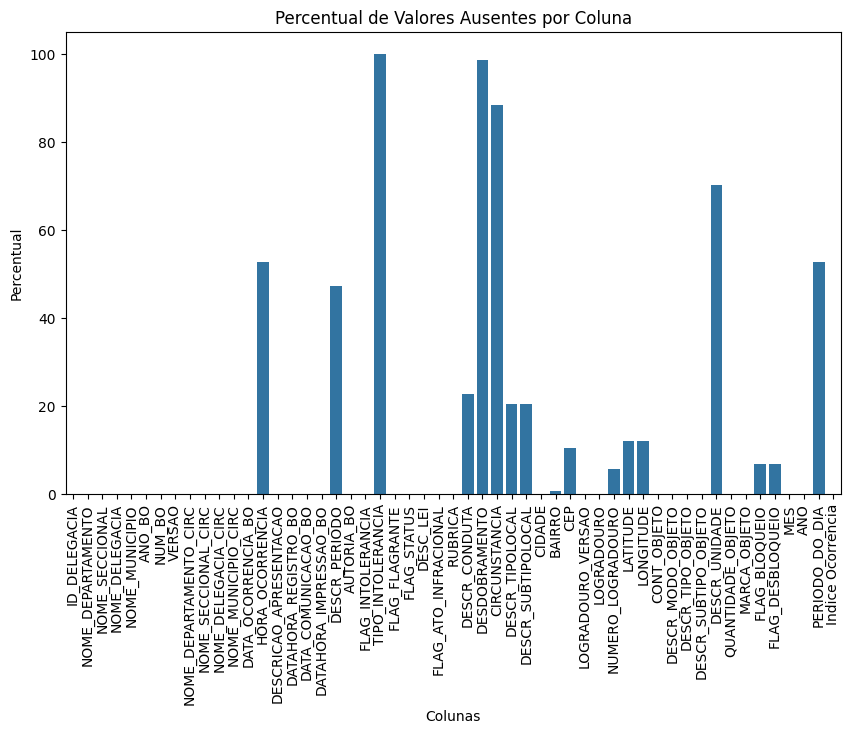

In [29]:
# Valores Ausentes
print("\nValores Ausentes por Coluna:")
# print(dados.isnull().sum())

# Distribuição de Valores Ausentes
print("\nDistribuição de Valores Ausentes (Percentual):")
missing_percentage = (dados.isnull().sum() / len(dados)) * 100
print(missing_percentage.sort_values(ascending=False))


# Visualização da Distribuição de Valores Ausentes
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_percentage.index, y=missing_percentage.values)
plt.xticks(rotation=90)
plt.title('Percentual de Valores Ausentes por Coluna')
plt.ylabel('Percentual')
plt.xlabel('Colunas')
plt.show()

## Pre processamento

In [18]:
# Madrugada: 0h - 5h
# Manhã: 6h - 11h
# Tarde: 12h - 17h
# Noite: 18h - 23h

dados_filter = dados.dropna(subset=['HORA_OCORRENCIA'])

dados_filter['HORA_OCORRENCIA'] = pd.to_datetime(dados_filter['HORA_OCORRENCIA'], format='%H:%M:%S').dt.hour

def categorizar_periodo(hora):
    if 0 <= hora < 6:
        return 'Madrugada'
    elif 6 <= hora < 12:
        return 'Manhã'
    elif 12 <= hora < 18:
        return 'Tarde'
    elif 18 <= hora < 24:
        return 'Noite'

# Aplicar a função de categorização
dados_filter['PERIODO_DO_DIA'] = dados_filter['HORA_OCORRENCIA'].apply(categorizar_periodo)

# Contar o número de ocorrências em cada período do dia
periodo_counts = dados_filter['PERIODO_DO_DIA'].value_counts().sort_index()

dados['PERIODO_DO_DIA'] = dados_filter['PERIODO_DO_DIA']
print(periodo_counts)

PERIODO_DO_DIA
Madrugada    416
Manhã        534
Noite        788
Tarde        462
Name: count, dtype: int64


/tmp/ipykernel_31540/1698926936.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_filter['HORA_OCORRENCIA'] = pd.to_datetime(dados_filter['HORA_OCORRENCIA'], format='%H:%M:%S').dt.hour
/tmp/ipykernel_31540/1698926936.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_filter['PERIODO_DO_DIA'] = dados_filter['HORA_OCORRENCIA'].apply(categorizar_periodo)


Corrige bairro com nome errado

In [19]:
import unicodedata

def normalize_string(s):
    if isinstance(s, str):
        s = unicodedata.normalize('NFKD', s).encode('ASCII', 'ignore').decode('utf-8')
        return s.upper()
    return s

# Aplicar a normalização à coluna 'BAIRRO'
dados['BAIRRO'] = dados['BAIRRO'].apply(normalize_string)

mapping = {
    'CAMPOS ELISIOS': 'CAMPOS ELISEOS',
    # Adicione outras correções específicas aqui, se necessário
}

# Função para aplicar o mapeamento
def correct_bairro(bairro):
    return mapping.get(bairro, bairro)

# Aplicar a correção à coluna 'BAIRRO'
dados['BAIRRO'] = dados['BAIRRO'].apply(correct_bairro)

# Agrupar pelos bairros corrigidos e somar as ocorrências
# dados = dados.groupby('BAIRRO')['COUNT'].sum().reset_index()
dados['BAIRRO'].value_counts()

BAIRRO
CENTRO                           446
JD JOQUEI CLUBE                  424
CAMPOS ELISEOS                   341
RIBEIRANIA                       124
PQ RIBEIRAO PRETO                115
                                ... 
CONDOMINIO VILLA BUENOS AIRES      1
REPUBLICA                          1
JARDIM PATRIARCA                   1
JARDIM JAMIL SEME CURY             1
RES E COM PALMARES                 1
Name: count, Length: 263, dtype: int64

## Analises iniciais


### Mapa de calor com crimes

In [14]:
map_center = [-21.1775, -47.8103]

def gera_heatmap(data, path_to_save):
    # Criar um mapa base
    mapa = folium.Map(location=map_center, zoom_start=12)

    # Adicionar os pontos de crimes como um mapa de calor
    heat_data = [[row['LATITUDE'], row['LONGITUDE']] for index, row in data.iterrows() if not pd.isnull(row['LATITUDE']) and not pd.isnull(row['LONGITUDE'])]
    HeatMap(heat_data).add_to(mapa)

    # Adicionar os pontos de crimes usando clusters
    marker_cluster = MarkerCluster().add_to(mapa)
    for index, row in data.iterrows():
        if not pd.isnull(row['LATITUDE']) and not pd.isnull(row['LONGITUDE']):
            folium.Marker(
                location=[row['LATITUDE'], row['LONGITUDE']],
                popup = (
                    f"Tipo de Local: {row['DESCR_TIPOLOCAL']}<br>"
                    f"Data: {row['DATA_OCORRENCIA_BO']}<br>"
                    f"Lat: {row['LATITUDE']}<br>"
                    f"Lng: {row['LONGITUDE']}"
                ),
                icon=folium.Icon(color='blue', icon='info-sign')
            ).add_to(marker_cluster)

    # Salvar o mapa em um arquivo HTML
    mapa.save(path_to_save)
    
path='../results/heatmap_rp_celular_2023.html'
gera_heatmap(dados, path)

In [37]:
# dados_filtered = dados[dados['PERIODO_DO_DIA']=='Madrugada']
# path='../results/heatmap_rp_celular_madrugada.html'
# gera_heatmap(dados_filtered, path)

# dados_filtered = dados[dados['PERIODO_DO_DIA']=='Noite']
# path='../results/heatmap_rp_celular_noite.html'
# gera_heatmap(dados_filtered, path)

# dados_filtered = dados[dados['PERIODO_DO_DIA']=='Manhã']
# path='../results/heatmap_rp_celular_manha.html'
# gera_heatmap(dados_filtered, path)

# dados_filtered = dados[dados['PERIODO_DO_DIA']=='Tarde']
# path='../results/heatmap_rp_celular_tarde.html'
# gera_heatmap(dados_filtered, path)


### Local com maior ocorrencia

In [30]:
dados['DESCR_TIPOLOCAL'].value_counts().head(5)

DESCR_TIPOLOCAL
Via Pública            3110
Residência              146
Lazer e Recreação        88
Comércio e Serviços      67
Terminal/Estação         52
Name: count, dtype: int64

/tmp/ipykernel_31540/1389323157.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Contagem', y='DESCR_TIPOLOCAL', data=top_5_locais_df, palette='rocket')


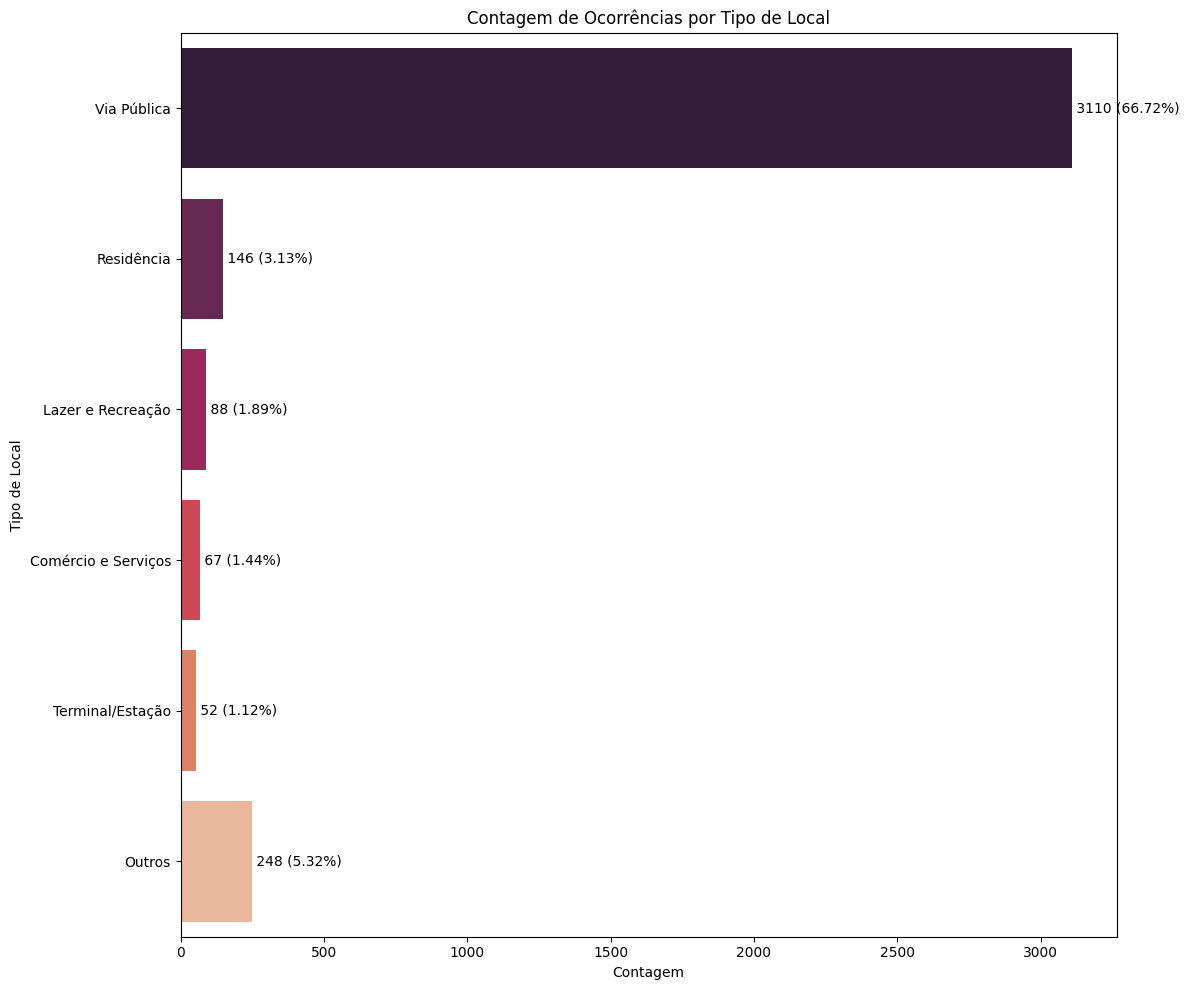

In [10]:

tipo_local_counts = dados.dropna(subset=['DESCR_TIPOLOCAL'])
tipo_local_counts = dados['DESCR_TIPOLOCAL'].value_counts()

top_5_locais = tipo_local_counts.head(5)
resto = tipo_local_counts[5:].sum()
top_5_locais['Outros'] = resto

# Reformatar os dados para um DataFrame
top_5_locais_df = top_5_locais.reset_index()
top_5_locais_df.columns = ['DESCR_TIPOLOCAL', 'Contagem']

# Plotando o gráfico
plt.figure(figsize=(12, 10))

# Barplot principal
sns.barplot(x='Contagem', y='DESCR_TIPOLOCAL', data=top_5_locais_df, palette='rocket')

# Adicionando informações de proporção dentro das barras
for index, value in enumerate(top_5_locais):
    plt.text(value, index, f' {value} ({value / len(dados) * 100:.2f}%)', ha='left', va='center', color='black')

# Configurações do gráfico
plt.title('Contagem de Ocorrências por Tipo de Local')
plt.xlabel('Contagem')
plt.ylabel('Tipo de Local')

# Ajustando o layout
plt.tight_layout()
plt.show()

In [13]:
tipo_counts = dados['RUBRICA'].value_counts()
print(tipo_counts)
tipo_counts['Outros'] = tipo_counts[~tipo_counts.index.isin(['Furto (art. 155)', 'Roubo (art. 157)', 'Perda/Extravio', 'Outros não criminal'])].sum()
tipo_counts = tipo_counts[['Furto (art. 155)', 'Roubo (art. 157)', 'Perda/Extravio', 'Outros', 'Outros não criminal']]

RUBRICA
Furto (art. 155)                                                                    2036
Roubo (art. 157)                                                                    1558
Perda/Extravio                                                                       775
Localização/Apreensão e Entrega de veículo                                            77
Outros não criminal                                                                   71
Estelionato (art. 171)                                                                19
Ameaça (art. 147)                                                                     18
Localização/Apreensão e Entrega de objeto                                             13
Lesão corporal (art. 129)                                                             13
Localização/Apreensão de veículo                                                      10
Localização/Apreensão de objeto                                                        8
Descumpriment

/tmp/ipykernel_31540/3035221084.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Contagem', y='RUBRICA', data=top_20_locais_df, palette='rocket')


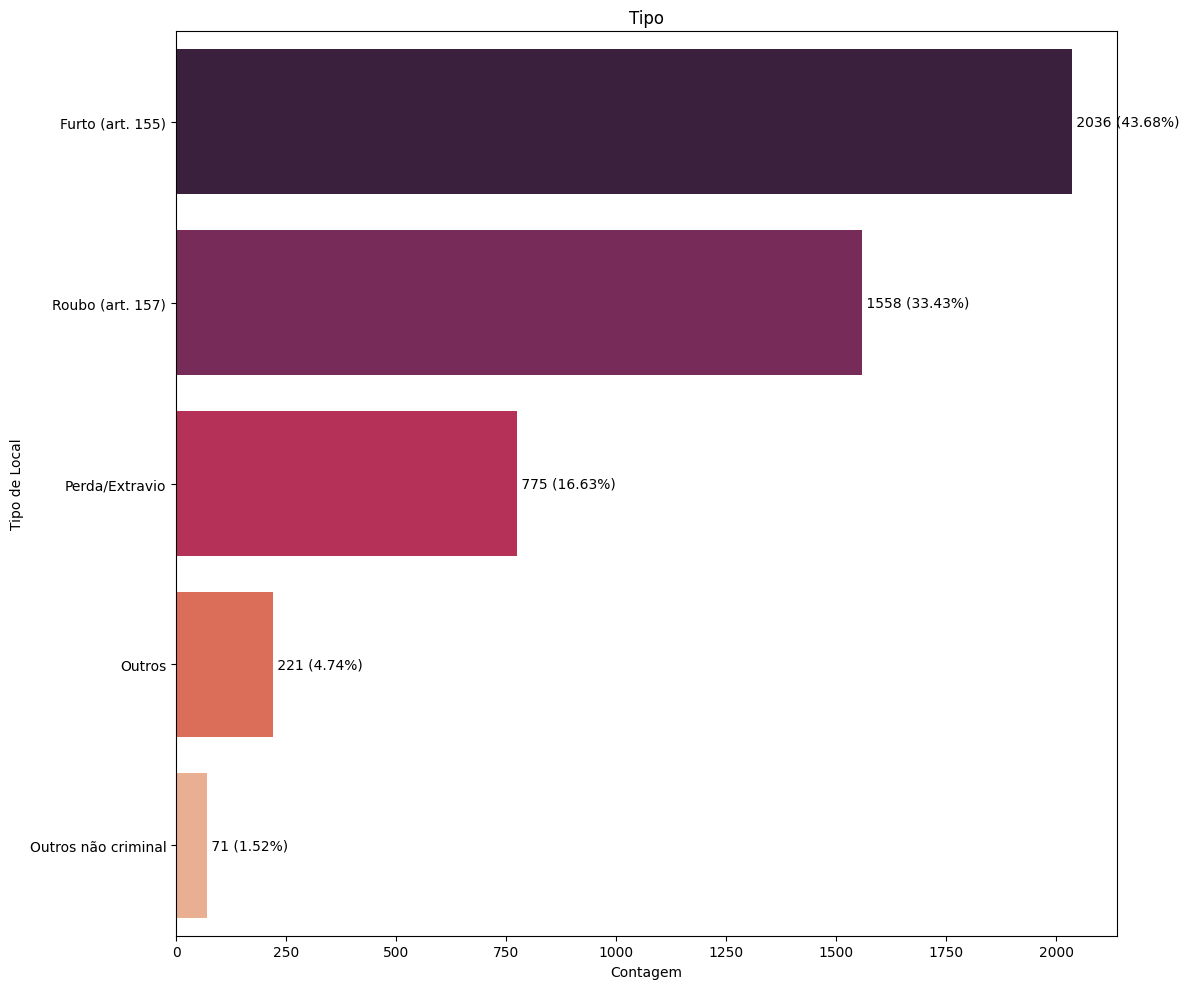

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
top_20_locais = tipo_counts.head(5)

# Reformatar os dados para um DataFrame
top_20_locais_df = top_20_locais.reset_index()
top_20_locais_df.columns = ['RUBRICA', 'Contagem']

# Plotando o gráfico
plt.figure(figsize=(12, 10))

# Barplot principal
sns.barplot(x='Contagem', y='RUBRICA', data=top_20_locais_df, palette='rocket')

# Adicionando informações de proporção dentro das barras
for index, value in enumerate(top_20_locais):
    plt.text(value, index, f' {value} ({value / len(dados) * 100:.2f}%)', ha='left', va='center', color='black')

# Configurações do gráfico
plt.title('Tipo')
plt.xlabel('Contagem')
plt.ylabel('Tipo de Local')

# Ajustando o layout
plt.tight_layout()
plt.show()


### Coordenadas paralelas

In [34]:
dados['Indice Ocorrencia'] = range(len(dados))
dados

# dados_filter_rp = dados.dropna(subset=['BAIRRO', 'PERIODO_DO_DIA'])

# Identificar os bairros com mais ocorrências
bairros_mais_ocorrencias = dados['BAIRRO'].value_counts().nlargest(4).index
bairros_mais_ocorrencias
dados_filter_rp = dados[dados['BAIRRO'].isin(bairros_mais_ocorrencias)].copy()
dados_filter_rp['BAIRRO'].value_counts()

BAIRRO
CENTRO             446
JD JOQUEI CLUBE    424
CAMPOS ELISEOS     341
RIBEIRANIA         124
Name: count, dtype: int64

In [35]:
dados_filter_rp['DATA_OCORRENCIA_BO'] = pd.to_datetime(dados_filter_rp['DATA_OCORRENCIA_BO'])

dados_filter_rp['mes_ocorrencia'] = dados_filter_rp['DATA_OCORRENCIA_BO'].dt.month

dados_filter_rp['bimestre_ocorrencia'] = (dados_filter_rp['mes_ocorrencia'] - 1) // 2 + 1


In [52]:
tipo_counts = dados_filter_rp['RUBRICA'].value_counts()
tipos_in=['Furto (art. 155)', 'Roubo (art. 157)', 'Perda/Extravio']
tipo_counts['Outros'] = tipo_counts[~tipo_counts.index.isin(tipos_in)].sum()
tipo_counts = tipo_counts[['Furto (art. 155)', 'Roubo (art. 157)', 'Perda/Extravio', 'Outros']]
tipo_counts

RUBRICA
Furto (art. 155)    857
Roubo (art. 157)    255
Perda/Extravio      178
Outros               45
Name: count, dtype: int64

In [53]:
dados_filter_rp.loc[~dados_filter_rp['RUBRICA'].isin(tipos_in), 'RUBRICA'] = 'Outros'

dados_filter_rp['RUBRICA'].value_counts()

RUBRICA
Furto (art. 155)    857
Roubo (art. 157)    255
Perda/Extravio      178
Outros               45
Name: count, dtype: int64

In [54]:
dados_filter_rp[['BAIRRO', 'RUBRICA', 'bimestre_ocorrencia']].head(5)

,BAIRRO,RUBRICA,bimestre_ocorrencia
23380,CENTRO,Furto (art. 155),1
23381,CENTRO,Roubo (art. 157),1
23383,CENTRO,Roubo (art. 157),1
23384,CENTRO,Roubo (art. 157),1
23385,CENTRO,Roubo (art. 157),1


In [58]:
# Mapear categorias para cores utilizando a paleta de cores do Seaborn
palette = sns.color_palette("tab10", len(dados_filter_rp['bimestre_ocorrencia'].unique()))
cor_por_categoria = dict(zip(dados_filter_rp['bimestre_ocorrencia'].unique(), palette))
cor_por_categoria_rgb = {cat: f'rgb({int(cor[0]*255)},{int(cor[1]*255)},{int(cor[2]*255)})' for cat, cor in cor_por_categoria.items()}

# Adicionar uma coluna de cores ao DataFrame com base na categoria
dados_filter_rp['COR'] = dados_filter_rp['bimestre_ocorrencia'].map(cor_por_categoria_rgb)

# Criar o gráfico de coordenadas paralelas
fig = px.parallel_categories(dados_filter_rp, dimensions=['BAIRRO', 'RUBRICA', 'bimestre_ocorrencia'],
                             color='COR', labels={'BAIRRO': 'Bairro', 'RUBRICA': 'Tipo', 'bimestre_ocorrencia': 'Bimestre'})

# Adicionar título
# fig.update_layout(title='Distribuição de Crimes por Categoria e Período do Dia nos Bairros com mais Ocorrências')

# Mostrar o gráfico
fig.write_html("../results/parallel_categories_rp_celular_2023.html")

In [59]:
# Mapear categorias para cores utilizando a paleta de cores do Seaborn
palette = sns.color_palette("tab10", len(dados_filter_rp['RUBRICA'].unique()))
cor_por_categoria = dict(zip(dados_filter_rp['RUBRICA'].unique(), palette))
cor_por_categoria_rgb = {cat: f'rgb({int(cor[0]*255)},{int(cor[1]*255)},{int(cor[2]*255)})' for cat, cor in cor_por_categoria.items()}

# Adicionar uma coluna de cores ao DataFrame com base na categoria
dados_filter_rp['COR'] = dados_filter_rp['RUBRICA'].map(cor_por_categoria_rgb)

# Criar o gráfico de coordenadas paralelas
fig = px.parallel_categories(dados_filter_rp, dimensions=['BAIRRO', 'bimestre_ocorrencia', 'RUBRICA'],
                             color='COR', labels={'BAIRRO': 'Bairro', 'bimestre_ocorrencia': 'bimestre_ocorrencia', 'RUBRICA': 'RUBRICA'})

# Adicionar título
fig.update_layout(title='Distribuição de Crimes por Categoria e Período do Dia nos Bairros com mais Ocorrências')

# Mostrar o gráfico
fig.write_html("../results/parallel_categories_rp_celular_2023.html")

### Analise tempo

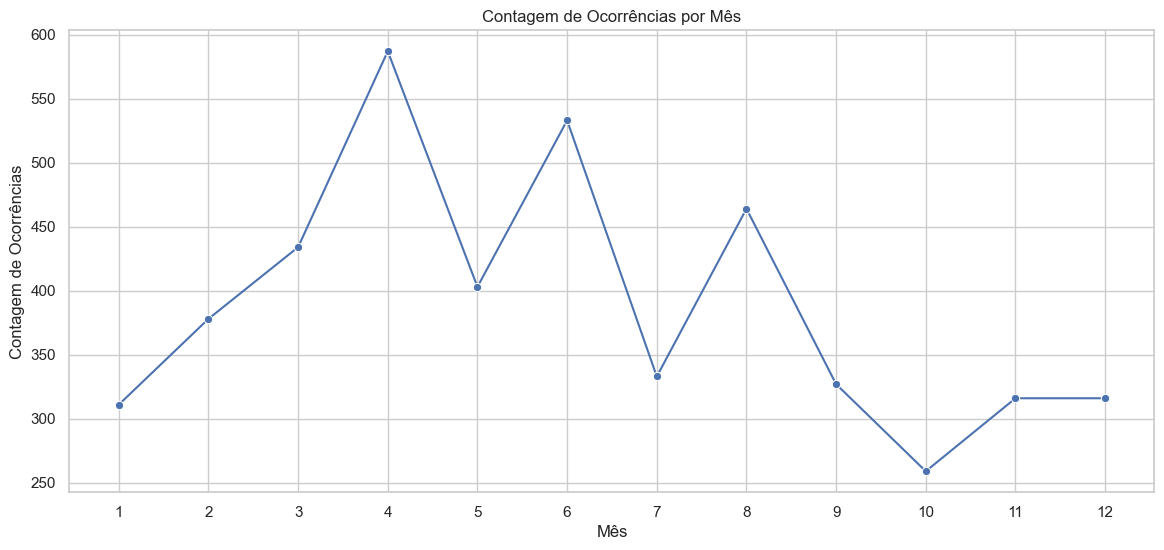

In [74]:
dados['DATA_OCORRENCIA_BO'] = pd.to_datetime(dados['DATA_OCORRENCIA_BO'])

dados['mes_ocorrencia'] = dados['DATA_OCORRENCIA_BO'].dt.month

dados['bimestre_ocorrencia'] = (dados['mes_ocorrencia'] - 1) // 2 + 1

dados[['BAIRRO', 'RUBRICA', 'bimestre_ocorrencia', 'mes_ocorrencia']]

# Agrupar por mês e contar as ocorrências
mensal_counts = dados.groupby('mes_ocorrencia').size().reset_index(name='Contagem')

# Agrupar por bimestre e contar as ocorrências
bimestral_counts = dados.groupby('bimestre_ocorrencia').size().reset_index(name='Contagem')

# Plotando o gráfico mensal
plt.figure(figsize=(14, 6))
sns.lineplot(x='mes_ocorrencia', y='Contagem', data=mensal_counts, marker='o')
plt.title('Contagem de Ocorrências por Mês')
plt.xlabel('Mês')
plt.ylabel('Contagem de Ocorrências')
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()


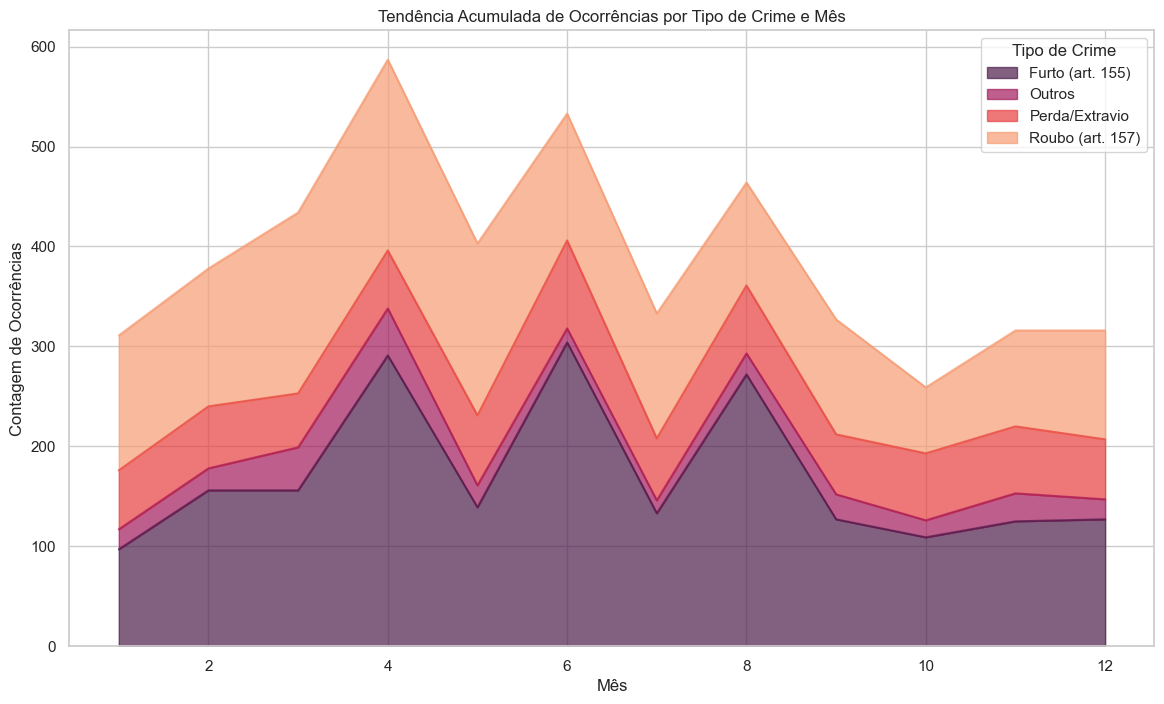

In [84]:
dados_cp=dados.copy()

dados_cp.loc[~dados_cp['RUBRICA'].isin(tipos_in), 'RUBRICA'] = 'Outros'

# Converter a coluna 'DATA_OCORRENCIA_BO' para datetime
dados_cp['DATA_OCORRENCIA_BO'] = pd.to_datetime(dados_cp['DATA_OCORRENCIA_BO'])

# Criar a coluna 'mes_ocorrencia'
dados_cp['mes_ocorrencia'] = dados_cp['DATA_OCORRENCIA_BO'].dt.month

# Agrupar dados_cp por mês e rubrica e contar ocorrências
area_data = dados_cp.groupby(['mes_ocorrencia', 'RUBRICA']).size().unstack(fill_value=0)

palette = sns.color_palette("rocket", len(area_data.columns))

# Plotar o gráfico de área
area_data.plot(kind='area', stacked=True, figsize=(14, 8),  color=palette, alpha=0.7)
plt.title('Tendência Acumulada de Ocorrências por Tipo de Crime e Mês')
plt.xlabel('Mês')
plt.ylabel('Contagem de Ocorrências')
plt.legend(title='Tipo de Crime')
plt.grid(True)
plt.show()


### Verificar periodo do dia com mais crimes / horario do dia 

/tmp/ipykernel_31540/1709736799.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_hora['HORA_OCORRENCIA'] = pd.to_datetime(dados_hora['HORA_OCORRENCIA'], format='%H:%M:%S').dt.hour


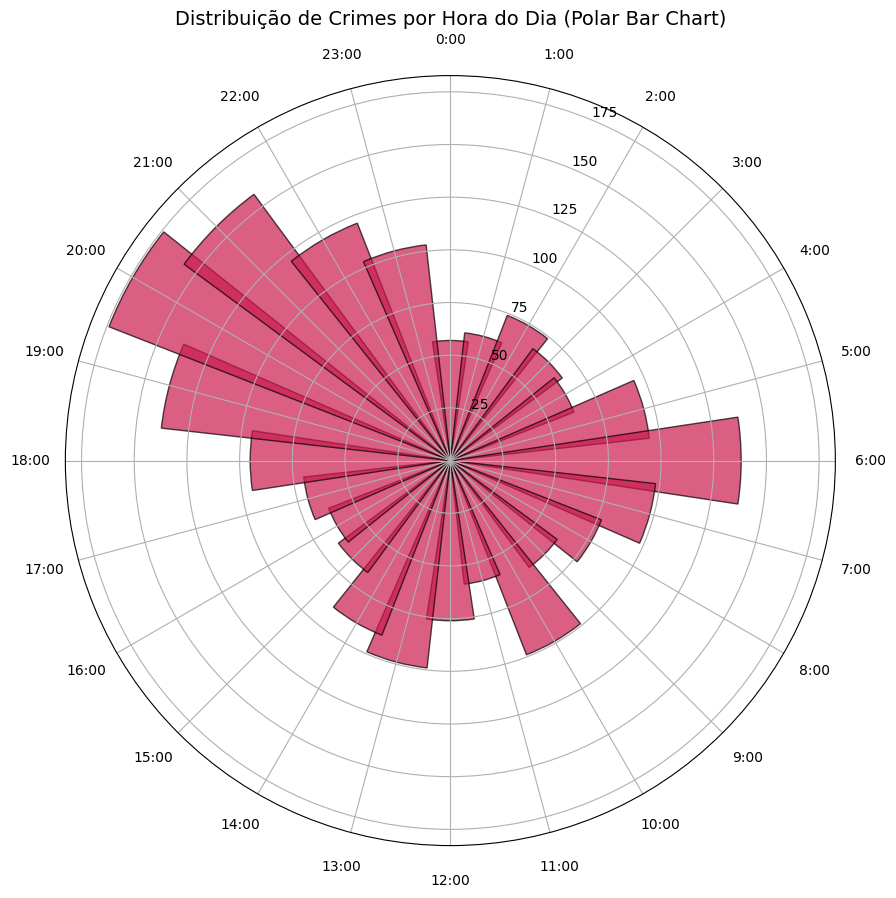

In [16]:
dados_hora = dados.dropna(subset=['HORA_OCORRENCIA'])

# Converter a coluna 'HORA_OCORRENCIA_BO' para o formato de hora
dados_hora['HORA_OCORRENCIA'] = pd.to_datetime(dados_hora['HORA_OCORRENCIA'], format='%H:%M:%S').dt.hour

# Agrupar os dados por hora e contar o número de ocorrências
hour_counts = dados_hora['HORA_OCORRENCIA'].value_counts().sort_index()

# Preparar os dados para o gráfico de barras polar
labels = hour_counts.index
values = hour_counts.values

# Criação do gráfico de barras polar
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Criação do ângulo para cada barra no sentido horário
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()

# Adicionar valores iniciais ao final para fechamento do gráfico
values = np.concatenate((values, [values[0]]))
angles += angles[:1]

palette = sns.color_palette("rocket", 1)
# Plot das barras
bars = ax.bar(angles[:-1], values[:-1], width=0.3, color=palette, edgecolor='black', alpha=0.7)

# Ajuste dos rótulos para seguir a ordem do relógio
ax.set_xticks(angles[:-1])
ax.set_xticklabels([f'{int(label)}:00' for label in labels])

# Rotacionar os labels para ficarem mais legíveis
ax.tick_params(axis='x', which='major', pad=15)

# Ajustar a posição do zero para o topo do gráfico e rotação para sentido horário
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)

# Adicionar título
plt.title('Distribuição de Crimes por Hora do Dia (Polar Bar Chart)', fontsize=14)

# Mostrar o gráfico
plt.show()


### Analise de correlação

In [59]:
dados.columns

Index(['ID_DELEGACIA', 'NOME_DEPARTAMENTO', 'NOME_SECCIONAL', 'NOME_DELEGACIA',
       'NOME_MUNICIPIO', 'ANO_BO', 'NUM_BO', 'VERSAO',
       'NOME_DEPARTAMENTO_CIRC', 'NOME_SECCIONAL_CIRC', 'NOME_DELEGACIA_CIRC',
       'NOME_MUNICIPIO_CIRC', 'DATA_OCORRENCIA_BO', 'HORA_OCORRENCIA',
       'DESCRICAO_APRESENTACAO', 'DATAHORA_REGISTRO_BO', 'DATA_COMUNICACAO_BO',
       'DATAHORA_IMPRESSAO_BO', 'DESCR_PERIODO', 'AUTORIA_BO',
       'FLAG_INTOLERANCIA', 'TIPO_INTOLERANCIA', 'FLAG_FLAGRANTE',
       'FLAG_STATUS', 'DESC_LEI', 'FLAG_ATO_INFRACIONAL', 'RUBRICA',
       'DESCR_CONDUTA', 'DESDOBRAMENTO', 'CIRCUNSTANCIA', 'DESCR_TIPOLOCAL',
       'DESCR_SUBTIPOLOCAL', 'CIDADE', 'BAIRRO', 'CEP', 'LOGRADOURO_VERSAO',
       'LOGRADOURO', 'NUMERO_LOGRADOURO', 'LATITUDE', 'LONGITUDE',
       'CONT_OBJETO', 'DESCR_MODO_OBJETO', 'DESCR_TIPO_OBJETO',
       'DESCR_SUBTIPO_OBJETO', 'DESCR_UNIDADE', 'QUANTIDADE_OBJETO',
       'MARCA_OBJETO', 'FLAG_BLOQUEIO', 'FLAG_DESBLOQUEIO', 'MES', 'ANO',
       '

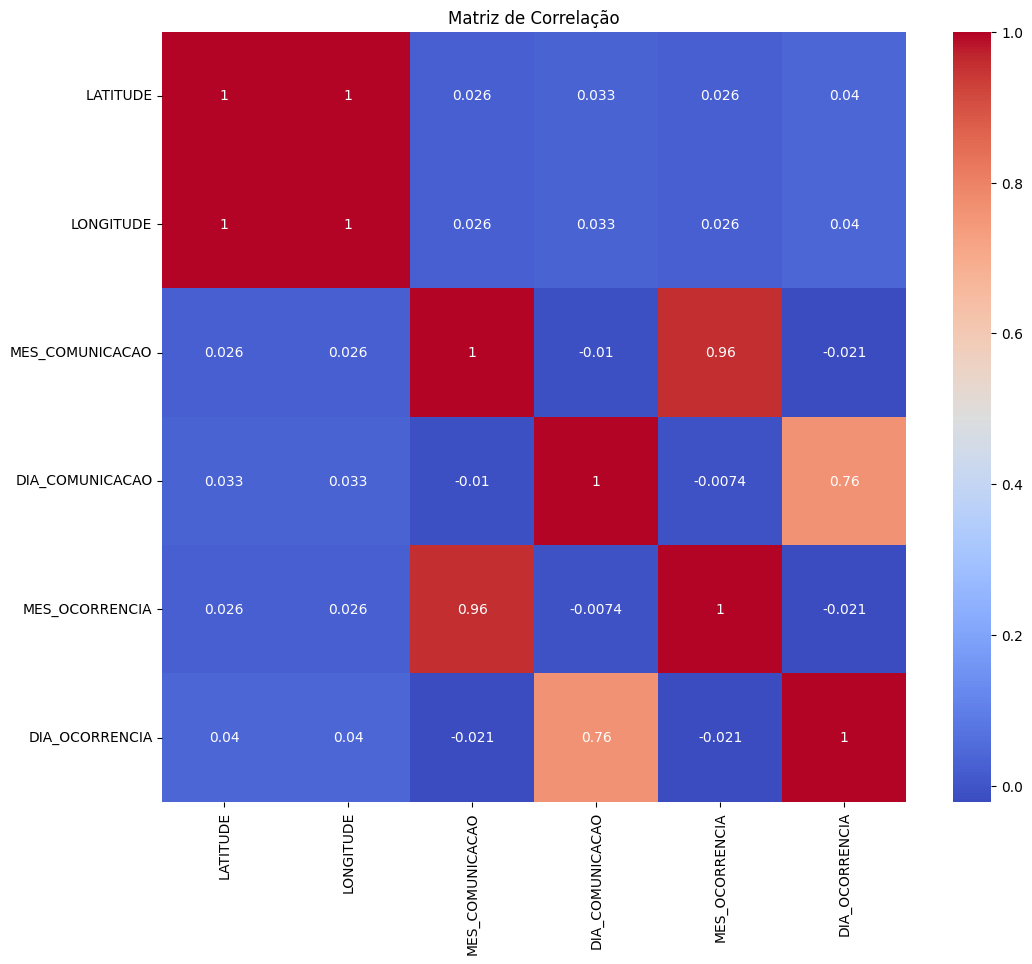

In [21]:
# Converter colunas de data para datetime
dados['DATA_COMUNICACAO_BO'] = pd.to_datetime(dados['DATA_COMUNICACAO_BO'])
dados['DATA_OCORRENCIA_BO'] = pd.to_datetime(dados['DATA_OCORRENCIA_BO'])

# Extrair partes da data para análise
dados['ANO_COMUNICACAO'] = dados['DATA_COMUNICACAO_BO'].dt.year
dados['MES_COMUNICACAO'] = dados['DATA_COMUNICACAO_BO'].dt.month
dados['DIA_COMUNICACAO'] = dados['DATA_COMUNICACAO_BO'].dt.day
dados['ANO_OCORRENCIA'] = dados['DATA_OCORRENCIA_BO'].dt.year
dados['MES_OCORRENCIA'] = dados['DATA_OCORRENCIA_BO'].dt.month
dados['DIA_OCORRENCIA'] = dados['DATA_OCORRENCIA_BO'].dt.day

# Selecionar as colunas relevantes para correlação
colunas_para_correlacao = [ 
                           'LATITUDE', 'LONGITUDE', 
                           'MES_COMUNICACAO', 'DIA_COMUNICACAO', 'MES_OCORRENCIA', 'DIA_OCORRENCIA']

dados_numericos = dados[colunas_para_correlacao]
dados_numericos
# Calcular a matriz de correlação entre variáveis numéricas
correlation_matrix = dados_numericos.corr()

# # Plotar o heatmap da matriz de correlação
plt.figure(figsize=(12, 10))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()


### Analise tempo ate o BO

Outra questão interessante é quanto tempo as pessoas esperam antes de denunciar o crime. Ao subtrair a data em que o crime ocorreu e foi denunciado, obtenho informações sobre o tempo de “atraso” e estratifico-os por crimes.

In [6]:
dados_cp=dados.copy()

# dados_cp.loc[~dados_cp['RUBRICA'].isin(tipos_in), 'RUBRICA'] = 'Outros'

dados_cp['RUBRICA'].value_counts()

RUBRICA
Furto (art. 155)                                                                    2036
Roubo (art. 157)                                                                    1558
Perda/Extravio                                                                       775
Localização/Apreensão e Entrega de veículo                                            77
Outros não criminal                                                                   71
Estelionato (art. 171)                                                                19
Ameaça (art. 147)                                                                     18
Localização/Apreensão e Entrega de objeto                                             13
Lesão corporal (art. 129)                                                             13
Localização/Apreensão de veículo                                                      10
Localização/Apreensão de objeto                                                        8
Descumpriment

In [7]:
dados['DATA_COMUNICACAO_BO'] = pd.to_datetime(dados['DATA_COMUNICACAO_BO'])
dados['DATA_OCORRENCIA_BO'] = pd.to_datetime(dados['DATA_OCORRENCIA_BO'])

# Calcular o tempo de atraso em dias
dados['TEMPO_ATRASO'] = (dados['DATA_COMUNICACAO_BO'] - dados['DATA_OCORRENCIA_BO']).dt.days

dados = dados[dados['TEMPO_ATRASO'] >= 0]

# Filtrar crimes que aparecem pelo menos 10 vezes
crime_counts = dados['RUBRICA'].value_counts()
crimes_filtrados = crime_counts[crime_counts >= 10].index
dados_filtrados = dados[dados['RUBRICA'].isin(crimes_filtrados)]

# Exibir os primeiros registros para verificar
print(len(dados_filtrados))
print(dados_filtrados[['DATA_OCORRENCIA_BO', 'DATA_COMUNICACAO_BO', 'TEMPO_ATRASO']].head())


4590
      DATA_OCORRENCIA_BO DATA_COMUNICACAO_BO  TEMPO_ATRASO
23380         2023-01-07          2023-01-09             2
23381         2023-01-11          2023-01-11             0
23382         2023-01-11          2023-01-11             0
23383         2023-01-10          2023-01-11             1
23384         2023-01-10          2023-01-11             1


In [8]:

atraso_por_crime = dados_filtrados.groupby('RUBRICA')['TEMPO_ATRASO'].describe()

print(len(atraso_por_crime))
# Exibir as estatísticas descritivas
print(atraso_por_crime.head(5))


10
                                   count       mean         std  min  25%  \
RUBRICA                                                                     
Ameaça (art. 147)                   18.0   3.444444    3.899053  0.0  1.0   
Estelionato (art. 171)              19.0   1.052632    0.911268  0.0  0.5   
Furto (art. 155)                  2036.0   7.834971  116.653380  0.0  0.0   
Lesão corporal (art. 129)           13.0  28.461538  101.119249  0.0  0.0   
Localização/Apreensão de veículo    10.0   0.200000    0.421637  0.0  0.0   

                                  50%  75%     max  
RUBRICA                                             
Ameaça (art. 147)                 3.0  3.0    16.0  
Estelionato (art. 171)            1.0  1.0     3.0  
Furto (art. 155)                  1.0  2.0  3652.0  
Lesão corporal (art. 129)         0.0  1.0   365.0  
Localização/Apreensão de veículo  0.0  0.0     1.0  


In [9]:
atraso_por_crime

crime_counts = dados['RUBRICA'].value_counts()
crimes_filtrados = crime_counts[crime_counts >= 10].index
dados_filtrados = dados[dados['RUBRICA'].isin(crimes_filtrados)]

# Criar os intervalos de tempo
intervalos = [-1, 0, 1, 2, 7, 30, 365, float('inf')]
labels = ['No mesmo dia', '1 dia de atraso', '2 dias', '3 a 7 dias', '8 a 30 dias', '30 dias a 1 ano', 'Mais de 1 ano']

# Adicionar uma nova coluna com a categoria de tempo de atraso
dados_filtrados['TEMPO_CATEGORIA'] = pd.cut(dados_filtrados['TEMPO_ATRASO'], bins=intervalos, labels=labels)

# Agrupar por crime e categoria de tempo de atraso
atraso_por_crime = dados_filtrados.groupby(['RUBRICA', 'TEMPO_CATEGORIA']).size().unstack(fill_value=0)

atraso_por_crime

/tmp/ipykernel_31540/1874908866.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_filtrados['TEMPO_CATEGORIA'] = pd.cut(dados_filtrados['TEMPO_ATRASO'], bins=intervalos, labels=labels)
/tmp/ipykernel_31540/1874908866.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  atraso_por_crime = dados_filtrados.groupby(['RUBRICA', 'TEMPO_CATEGORIA']).size().unstack(fill_value=0)


TEMPO_CATEGORIA,No mesmo dia,1 dia de atraso,2 dias,3 a 7 dias,8 a 30 dias,30 dias a 1 ano,Mais de 1 ano
RUBRICA,,,,,,,
Ameaça (art. 147),3,3,1,9,2,0,0
Estelionato (art. 171),5,10,2,2,0,0,0
Furto (art. 155),756,639,232,260,100,42,7
Lesão corporal (art. 129),8,3,1,0,0,1,0
Localização/Apreensão de veículo,8,2,0,0,0,0,0
Localização/Apreensão e Entrega de objeto,8,3,2,0,0,0,0
Localização/Apreensão e Entrega de veículo,48,25,1,2,1,0,0
Outros não criminal,26,16,4,17,3,5,0
Perda/Extravio,294,210,81,120,54,14,2


Index(['Ameaça (art. 147)', 'Estelionato (art. 171)', 'Furto (art. 155)',
       'Lesão corporal (art. 129)', 'Localização/Apreensão de veículo',
       'Localização/Apreensão e Entrega de objeto',
       'Localização/Apreensão e Entrega de veículo', 'Outros não criminal',
       'Perda/Extravio', 'Roubo (art. 157)'],
      dtype='object', name='RUBRICA')
Index(['Ameaça (art. 147)', 'Estelionato (art. 171)', 'Furto (art. 155)',
       'Lesão corporal (art. 129)', 'Localização/Apreensão de veículo',
       'Localização/Apreensão e Entrega de objeto',
       'Localização/Apreensão e Entrega de veículo', 'Outros não criminal',
       'Perda/Extravio', 'Roubo (art. 157)'],
      dtype='object', name='RUBRICA')
Index(['Ameaça (art. 147)', 'Estelionato (art. 171)', 'Furto (art. 155)',
       'Lesão corporal (art. 129)', 'Localização/Apreensão de veículo',
       'Localização/Apreensão e Entrega de objeto',
       'Localização/Apreensão e Entrega de veículo', 'Outros não criminal',
       'Pe

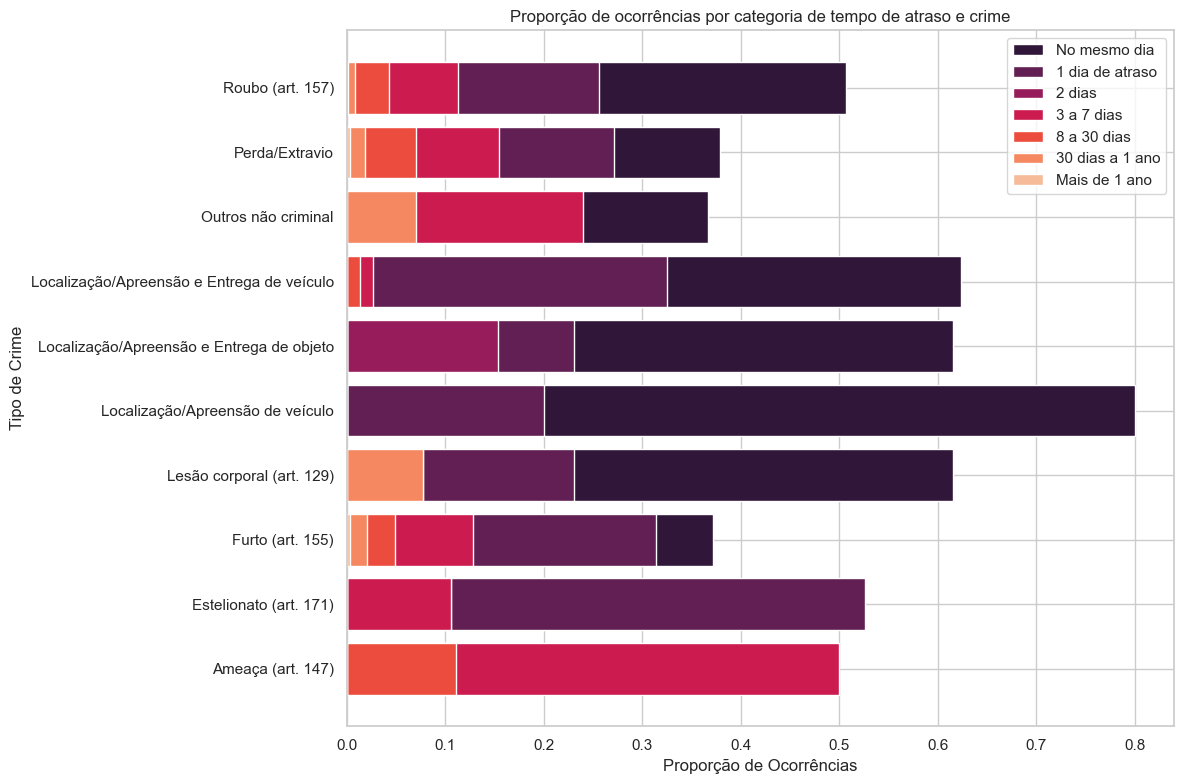

In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Suponha que você já tenha os dados e tenha feito as operações necessárias para criar o dataframe 'atraso_por_crime'

# Configurar o estilo e tamanho do gráfico
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

# Calcular o total de ocorrências para cada tipo de crime
atraso_por_crime['Total'] = atraso_por_crime[labels].sum(axis=1)

# Calcular a proporção em relação ao total para cada categoria de tempo de atraso
for categoria in labels:
    atraso_por_crime[categoria] = atraso_por_crime[categoria] / atraso_por_crime['Total']

# Definir uma paleta de cores diferente
cores = sns.color_palette("rocket", len(labels))

# Plotar o histograma empilhado
for i, categoria in enumerate(labels):
    print(atraso_por_crime.index)
    plt.barh(atraso_por_crime.index, atraso_por_crime[categoria], label=categoria, color=cores[i])

# Adicionar legenda
plt.legend()

# Adicionar título e rótulos nos eixos
plt.title('Proporção de ocorrências por categoria de tempo de atraso e crime')
plt.xlabel('Proporção de Ocorrências')
plt.ylabel('Tipo de Crime')

# Mostrar o gráfico
plt.tight_layout()
plt.show()
